<H3><b>Fine Tuning ResNet18, ResNet34 and ResNet50 by adding two fully connected layers and three batch normalisation layers

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torchsummary import summary
import numpy as np
import torchvision
from torchvision.transforms import v2

from torchvision import datasets, models
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cudnn.benchmark = True
plt.ion()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive"

'Admin Events and EM - Team Report.gdoc'  'images dataset.zip'
'Colab Notebooks'			  'Untitled presentation.gslides'


In [ ]:
!unzip -q "/content/drive/My Drive/images dataset.zip" -d "/content/dataset"


In [ ]:
path = "/content/dataset"


In [ ]:
# Define transforms for data augmentation and normalization
transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:

train_dataset = datasets.ImageFolder(root=path+"/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

validation_dataset = datasets.ImageFolder(root=path+"/valid", transform=transform)
validation_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder(root=path+"/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train':train_loader, 'valid':validation_loader, 'test':test_loader}

# Determine dataset sizes
dataset_sizes = {}
dataset_sizes['train'] = len(train_dataset)
dataset_sizes['valid'] = len(validation_dataset)
dataset_sizes['test'] = len(test_dataset)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define function for training a model
def train_model(model, criterion, optimizer, dataloaders, num_epochs=5):
    model.to(device)
    train_acc_history = []
    valid_acc_history = []

    train_loss_history = []
    valid_loss_history = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # print(inputs)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
            else:
                valid_acc_history.append(epoch_acc)

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                valid_loss_history.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    return model, train_acc_history, valid_acc_history, train_loss_history, valid_loss_history

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Collect predictions and true labels
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    print('Accuracy: {:.4f}'.format(accuracy))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1-score: {:.4f}'.format(f1))


<h4><b>ResNet18


In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 51.0MB/s]


In [ ]:
# Modify the model head for fine-tuning
num_features = model.fc.in_features

num_classes = 2

# Define the new model head
model.fc = nn.Sequential(
    nn.BatchNorm1d(num_features),   # Batch normalization layer
    nn.Linear(num_features, 128),   # First FC layer with 256 output features
    nn.BatchNorm1d(128),            # Second dropout layer with 30% probability
    nn.Linear(128, 16),
    nn.BatchNorm1d(16),
    nn.Linear(16, num_classes),              # Final FC layer for prediction
)

In [ ]:
print(model)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model, train_acc_resnet18, valid_acc_resnet18, train_loss_resnet18, valid_loss_resnet18 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=7)


Epoch 1/7
----------
train Loss: 0.4362 Acc: 0.7942
valid Loss: 0.3453 Acc: 0.8391
Epoch 2/7
----------
train Loss: 0.2586 Acc: 0.9156
valid Loss: 0.1838 Acc: 0.9614
Epoch 3/7
----------
train Loss: 0.1676 Acc: 0.9649
valid Loss: 0.1250 Acc: 0.9846
Epoch 4/7
----------
train Loss: 0.1214 Acc: 0.9823
valid Loss: 0.0768 Acc: 0.9957
Epoch 5/7
----------
train Loss: 0.0903 Acc: 0.9894
valid Loss: 0.0555 Acc: 0.9972
Epoch 6/7
----------
train Loss: 0.0800 Acc: 0.9909
valid Loss: 0.0574 Acc: 0.9980
Epoch 7/7
----------
train Loss: 0.0602 Acc: 0.9949
valid Loss: 0.0433 Acc: 0.9996


In [ ]:
print("Evaluating resnet18 on the test set...")
evaluate_model(model, dataloaders['test'])

Evaluating resnet18 on the test set...
Accuracy: 0.8900
Precision: 0.9398
Recall: 0.8333
F1-score: 0.8834


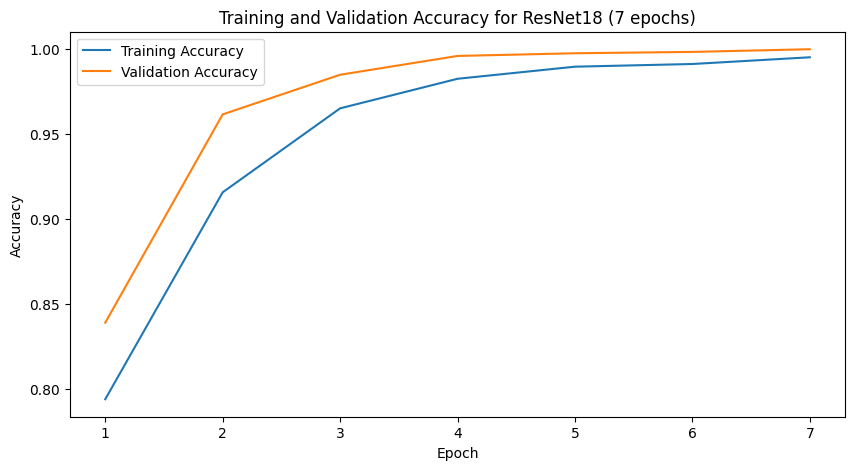

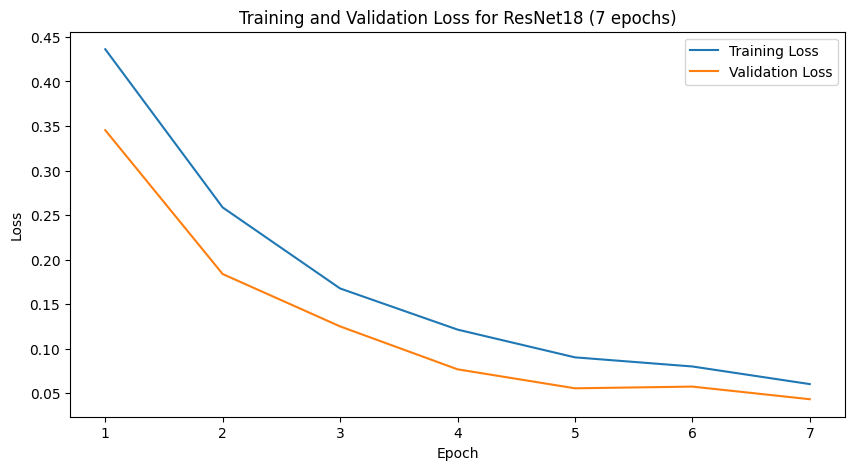

In [ ]:
# Move the accuracies to CPU
train_acc_resnet18_cpu = [acc.cpu().numpy() for acc in train_acc_resnet18]
valid_acc_resnet18_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet18]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet18_cpu) + 1), train_acc_resnet18_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet18_cpu) + 1), valid_acc_resnet18_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet18 (7 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet18) + 1), train_loss_resnet18, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet18) + 1), valid_loss_resnet18, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet18 (7 epochs)')
plt.legend()
plt.show()

<h4><b>ResNet34


In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 166MB/s]


In [ ]:
# Modify the model head for fine-tuning
num_features = model.fc.in_features

num_classes = 2

# Define the new model head
model.fc = nn.Sequential(
    nn.BatchNorm1d(num_features),   # Batch normalization layer
    nn.Linear(num_features, 128),   # First FC layer with 256 output features
    nn.BatchNorm1d(128),            # Second dropout layer with 30% probability
    nn.Linear(128, 16),
    nn.BatchNorm1d(16),
    nn.Linear(16, num_classes),              # Final FC layer for prediction
)

In [ ]:
print(model)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model, train_acc_resnet34, valid_acc_resnet34, train_loss_resnet34, valid_loss_resnet34 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=7)


Epoch 1/7
----------
train Loss: 0.4228 Acc: 0.8013
valid Loss: 0.2182 Acc: 0.9267
Epoch 2/7
----------
train Loss: 0.2220 Acc: 0.9192
valid Loss: 0.1680 Acc: 0.9503
Epoch 3/7
----------
train Loss: 0.1716 Acc: 0.9405
valid Loss: 0.0935 Acc: 0.9842
Epoch 4/7
----------
train Loss: 0.1130 Acc: 0.9748
valid Loss: 0.1004 Acc: 0.9767
Epoch 5/7
----------
train Loss: 0.0808 Acc: 0.9830
valid Loss: 0.0501 Acc: 0.9965
Epoch 6/7
----------
train Loss: 0.0638 Acc: 0.9917
valid Loss: 0.0497 Acc: 0.9945
Epoch 7/7
----------
train Loss: 0.0643 Acc: 0.9842
valid Loss: 0.0461 Acc: 0.9957


In [ ]:
print("Evaluating resnet34 on the test set...")
evaluate_model(model, dataloaders['test'])

Evaluating resnet34 on the test set...
Accuracy: 0.8767
Precision: 0.9124
Recall: 0.8333
F1-score: 0.8711


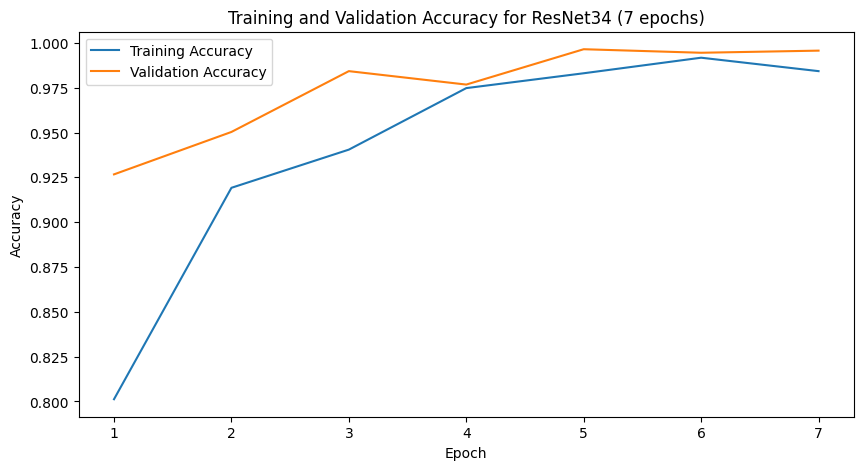

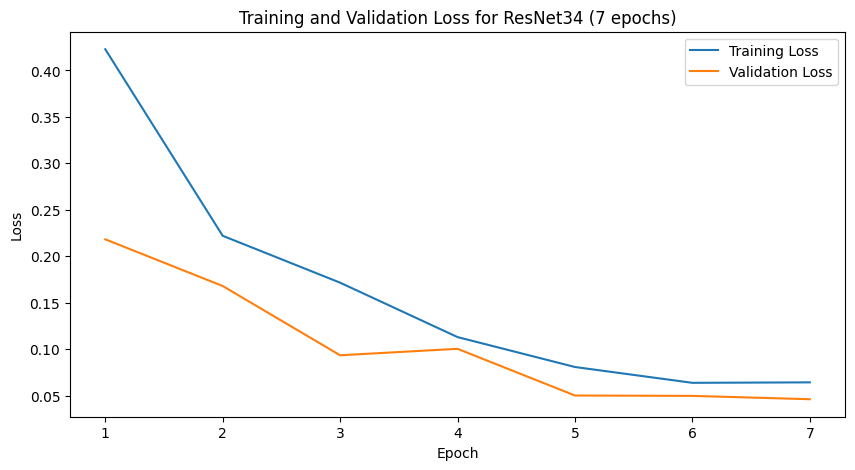

In [ ]:
# Move the accuracies to CPU
train_acc_resnet34_cpu = [acc.cpu().numpy() for acc in train_acc_resnet34]
valid_acc_resnet34_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet34]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet34_cpu) + 1), train_acc_resnet34_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet34_cpu) + 1), valid_acc_resnet34_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet34 (7 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet34) + 1), train_loss_resnet34, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet34) + 1), valid_loss_resnet34, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet34 (7 epochs)')
plt.legend()
plt.show()

<h4><b>ResNet50


In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s]


In [ ]:
# Modify the model head for fine-tuning
num_features = model.fc.in_features

num_classes = 2

# Define the new model head
model.fc = nn.Sequential(
    nn.BatchNorm1d(num_features),   # Batch normalization layer
    nn.Linear(num_features, 128),   # First FC layer with 256 output features
    nn.BatchNorm1d(128),            # Second dropout layer with 30% probability
    nn.Linear(128, 16),
    nn.BatchNorm1d(16),
    nn.Linear(16, num_classes),              # Final FC layer for prediction
)

In [ ]:
print(model)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model, train_acc_resnet50, valid_acc_resnet50, train_loss_resnet50, valid_loss_resnet50 = train_model(model, criterion, optimizer_ft, dataloaders,
                       num_epochs=7)


Epoch 1/7
----------
train Loss: 0.4318 Acc: 0.7973
valid Loss: 0.2017 Acc: 0.9345
Epoch 2/7
----------
train Loss: 0.2112 Acc: 0.9298
valid Loss: 0.1394 Acc: 0.9759
Epoch 3/7
----------
train Loss: 0.1471 Acc: 0.9562
valid Loss: 0.0838 Acc: 0.9878
Epoch 4/7
----------
train Loss: 0.1273 Acc: 0.9673
valid Loss: 0.0960 Acc: 0.9767
Epoch 5/7
----------
train Loss: 0.0971 Acc: 0.9799
valid Loss: 0.0525 Acc: 0.9968
Epoch 6/7
----------
train Loss: 0.0711 Acc: 0.9886
valid Loss: 0.0455 Acc: 0.9976
Epoch 7/7
----------
train Loss: 0.0545 Acc: 0.9945
valid Loss: 0.0301 Acc: 0.9992


In [ ]:
print("Evaluating resnet50 on the test set...")
evaluate_model(model, dataloaders['test'])

Evaluating resnet50 on the test set...
Accuracy: 0.9033
Precision: 0.8854
Recall: 0.9267
F1-score: 0.9055


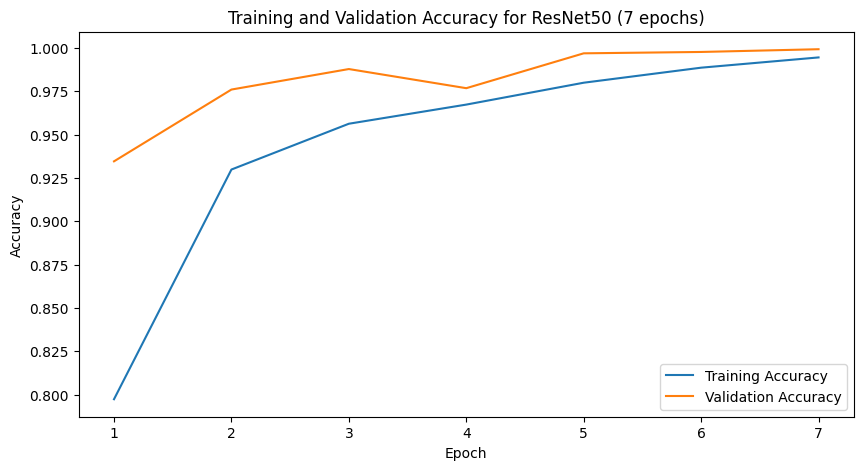

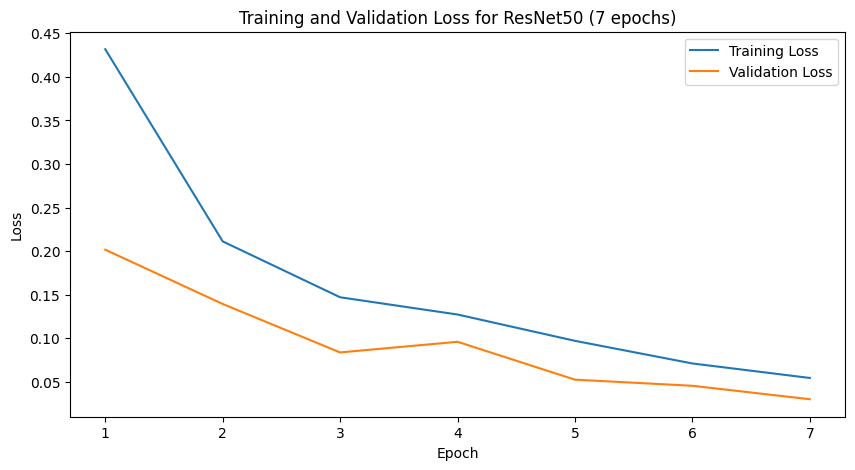

In [ ]:
# Move the accuracies to CPU
train_acc_resnet50_cpu = [acc.cpu().numpy() for acc in train_acc_resnet50]
valid_acc_resnet50_cpu = [acc.cpu().numpy() for acc in valid_acc_resnet50]
# print(train_acc_resnet34)
# print(train_loss_resnet34)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_resnet50_cpu) + 1), train_acc_resnet50_cpu, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_resnet50_cpu) + 1), valid_acc_resnet50_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet50 (7 epochs)')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_resnet50) + 1), train_loss_resnet50, label='Training Loss')
plt.plot(range(1, len(valid_loss_resnet50) + 1), valid_loss_resnet50, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet50 (7 epochs)')
plt.legend()
plt.show()